## Prepare Input Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd  /content/drive/MyDrive/Comma_Controls_Challenge/

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
  print('Good to go!')
else:
  print('Please set GPU via the downward triangle in the top right corner.')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/19HhYMD2MUiW4NQhMcsCEtjt55jGb8lZY/Comma_Controls_Challenge
Good to go!


In [2]:
from tqdm import tqdm
import pandas as pd
import numpy as np

from typing import List, Union, Tuple
from pathlib import Path

ACC_G = 9.81
DATA_POINTS_PER_FILE = 100

In [19]:
top_data_path = Path("./data")
num_segs = 100

In [20]:
def get_data(data_path: str) -> pd.DataFrame:
    df = pd.read_csv(data_path)
    processed_df = pd.DataFrame({
      'roll_lataccel': np.sin(df['roll'].values) * ACC_G,
      'v_ego': df['vEgo'].values,
      'a_ego': df['aEgo'].values,
      'target_lataccel': df['targetLateralAcceleration'].values,
      'steer_command': df['steerCommand'].values
    })
    return processed_df

def get_state_target(data_file: pd.DataFrame, step_idx: int) -> Tuple[dict, float]:
    state = data_file.iloc[step_idx]

    # Here we assume target lataccel == current lataccel
    return {'roll_lataccel': state['roll_lataccel'], 'v_ego': state['v_ego'], 'a_ego': state['a_ego']}, state['steer_command']


In [21]:
pid_outputs = []

with open("data/new_pid_outputs.txt", "r") as file:
    # Read each line in the file
    for line in file:
        # Strip any whitespace (including newline characters) and split by comma
        numbers = line.strip().split(",")
        # Extract the first number and append to the list
        first_number = numbers[0]
        pid_outputs.append(float(first_number))

pid_outputs = pid_outputs[:num_segs * 80]
# Print the list of first numbers
print(len(pid_outputs))
print(type(pid_outputs[0]))
print(pid_outputs[:5])

8000
<class 'float'>
[0.0005941202763970897, -0.0017096476234114172, -0.005536173705830045, -0.03270896581188096, -0.03609294678423933]


In [18]:
target_lataccels = []
roll_lataccels = []
v_egos = []
a_egos = []

prepared_data = []
files = sorted(top_data_path.iterdir())[:num_segs]
for file_num, data_file in enumerate(tqdm(files, total=len(files))):
    data_path = str(data_file)
    file_df = get_data(data_path)

    for i in range(DATA_POINTS_PER_FILE):
      if i >= 20:
        input_dict, target_steer = get_state_target(file_df, i)
        pid_steer = pid_outputs[(file_num * 80 + i) - 20]
        #print(f"File num: {file_num}, Number : {i-20}: {pid_steer}")
        steer_diff_target = target_steer - pid_steer
        prepared_data.append([input_dict, steer_diff_target])

print(len(prepared_data))
print(prepared_data[0])

100%|██████████| 100/100 [00:01<00:00, 62.40it/s]

8000
[{'roll_lataccel': 0.3721846564960506, 'v_ego': 33.6662993138583, 'a_ego': -0.1427389358746498}, -0.3230357535909335]


### View statistics of input and output data

In [22]:
from tabulate import tabulate

# Extract inputs and outputs
inputs = [d[0] for d in prepared_data]
outputs = [d[1] for d in prepared_data]

def pretty_stats(inputs, outputs):
    # Create a list to store the statistics
    statistics = []

    # Compute statistics for each feature
    for key in inputs[0].keys():
        feature_values = [sample[key] for sample in inputs]
        mean = np.mean(feature_values)
        std_dev = np.std(feature_values)
        min_val = np.min(feature_values)
        max_val = np.max(feature_values)
        quantiles = np.percentile(feature_values, [25, 50, 75])
        statistics.append([key, mean, std_dev, min_val, max_val, quantiles[0], quantiles[1], quantiles[2]])

    # Compute statistics for the target output
    mean_output = np.mean(outputs)
    std_dev_output = np.std(outputs)
    min_output = np.min(outputs)
    max_output = np.max(outputs)
    quantiles_output = np.percentile(outputs, [25, 50, 75])
    statistics.append(['Target Output', mean_output, std_dev_output, min_output, max_output, quantiles_output[0], quantiles_output[1], quantiles_output[2]])

    # Output the statistics in a nice table format
    headers = ["Feature", "Mean", "Std Dev", "Min", "Max", "25th Percentile", "Median (50th Percentile)", "75th Percentile"]
    print(tabulate(statistics, headers=headers, tablefmt="grid"))

pretty_stats(inputs, outputs)

+---------------+------------+-----------+-----------+-----------+-------------------+----------------------------+-------------------+
| Feature       |       Mean |   Std Dev |       Min |       Max |   25th Percentile |   Median (50th Percentile) |   75th Percentile |
+===============+============+===========+===========+===========+===================+============================+===================+
| roll_lataccel |  0.134498  |  0.259413 | -0.733682 |  0.999905 |         0.0129015 |                  0.174734  |          0.310311 |
+---------------+------------+-----------+-----------+-----------+-------------------+----------------------------+-------------------+
| v_ego         | 23.2484    |  9.49457  |  0        | 36.7801   |        16.5876    |                 26.7239    |         30.7188   |
+---------------+------------+-----------+-----------+-----------+-------------------+----------------------------+-------------------+
| a_ego         |  0.0719479 |  0.472535 | -3.14

### Normalize inputs to 0 mean and unit s.d. and visualize

In [23]:
from sklearn.preprocessing import StandardScaler

input_array = np.array([list(sample.values()) for sample in inputs])
scaler = StandardScaler()
normalized_inputs = scaler.fit_transform(input_array)

In [24]:
normalized_inputs_list = [dict(zip(inputs[0].keys(), row)) for row in normalized_inputs]

pretty_stats(normalized_inputs_list, outputs)

+---------------+-------------+-----------+----------+---------+-------------------+----------------------------+-------------------+
| Feature       |        Mean |   Std Dev |      Min |     Max |   25th Percentile |   Median (50th Percentile) |   75th Percentile |
+===============+=============+===========+==========+=========+===================+============================+===================+
| roll_lataccel | 1.47082e-15 |  1        | -3.34671 | 3.33602 |        -0.468738  |                  0.155103  |          0.677734 |
+---------------+-------------+-----------+----------+---------+-------------------+----------------------------+-------------------+
| v_ego         | 2.87059e-15 |  1        | -2.4486  | 1.4252  |        -0.701541  |                  0.366043  |          0.786804 |
+---------------+-------------+-----------+----------+---------+-------------------+----------------------------+-------------------+
| a_ego         | 3.2685e-16  |  1        | -6.79901 | 4.19226

### Create neural network

In [25]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import torch.optim as optim

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, h0=None, c0=None):
        # If initial hidden and cell states are not provided, initialize them
        if h0 is None:
            h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        if c0 is None:
            c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        if x.dim() == 1:
            out, (hn, cn) = self.lstm(x.unsqueeze(1), (h0, c0))
            out = self.fc(out.squeeze(1))
        else:
            out, (hn, cn) = self.lstm(x, (h0, c0))
            out = self.fc(out)

        return out, (hn, cn)

In [11]:
import torch.nn.init as init

# Initialize weights using Xavier initialization
def initialize_weights_xavier(model):
    for name, param in model.named_parameters():
        if 'weight' in name:
            init.xavier_uniform_(param.data)
        elif 'bias' in name:
            param.data.fill_(0.01)  # Initialize bias with small constant value

In [26]:
input_tensor = torch.tensor(normalized_inputs, dtype=torch.float32).to(device)

# Convert outputs to PyTorch tensor
output_tensor = torch.tensor(outputs, dtype=torch.float32).view(-1, 1).to(device)

criterion = nn.MSELoss()

print(input_tensor.size())
print(output_tensor.size())

torch.Size([8000, 3])
torch.Size([8000, 1])


In [ ]:
import torch

# Create tensor of shape (100, 5) with four zeros and current index number
tensor_5d = torch.arange(1, 101, dtype=torch.float32).unsqueeze(1).repeat(1, 5)
tensor_5d[:, :4] = 0

# Create tensor of shape (100, 1) with current index number
tensor_1d = torch.arange(1, 101, dtype=torch.float32).unsqueeze(1)

print("5D Tensor:")
print(tensor_5d)
print("\n1D Tensor:")
print(tensor_1d)


In [ ]:
!pip install wandb

In [14]:
import wandb

wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

6400


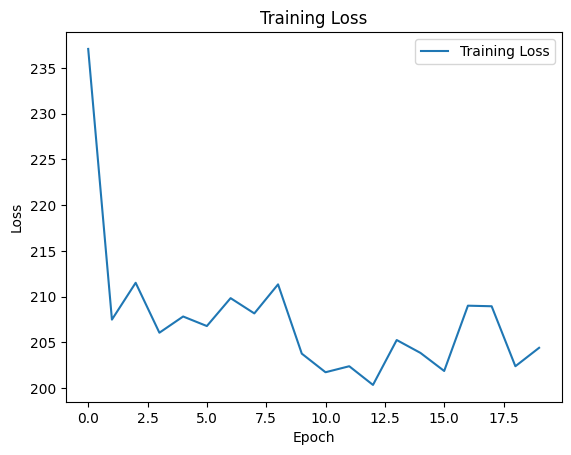

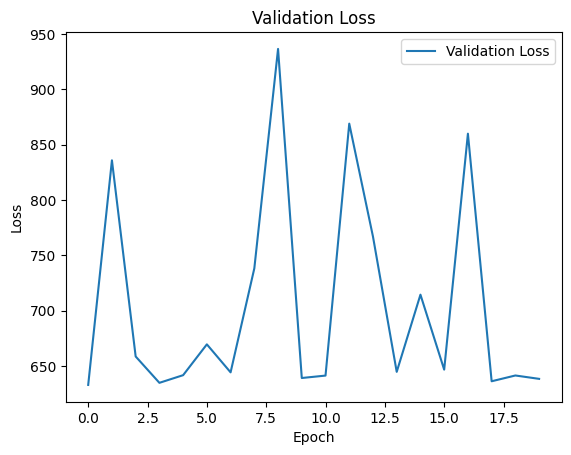

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np


wandb.init(project="commacontrols_diff", settings=wandb.Settings(start_method="fork"))

train_tensor = torch.tensor(normalized_inputs[:int(len(normalized_inputs) * 0.8)], dtype=torch.float32).to(device)

group_size = 1000

print(train_tensor.size(0))

train_tensor_batched = train_tensor.chunk(train_tensor.size(0) // group_size, dim=0)

# Convert outputs to PyTorch tensor
train_output_tensor = torch.tensor(outputs[:int(len(normalized_inputs) * 0.8)], dtype=torch.float32).view(-1, 1).to(device)

train_output_tensor_batched = train_output_tensor.chunk(train_output_tensor.size(0) // group_size, dim=0)

val_tensor = torch.tensor(normalized_inputs[int(len(normalized_inputs) * 0.8):], dtype=torch.float32).unsqueeze(0).to(device)

val_output_tensor = torch.tensor(outputs[int(len(normalized_inputs) * 0.8):], dtype=torch.float32).view(1, -1, 1).to(device)



# Assuming CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_epochs = 20
train_losses = []  # List to store loss values
val_losses = []

input_size = len(inputs[0])  # Number of input features
hidden_size = 150  # Number of hidden units
num_layers = 3  # Number of LSTM layers
output_size = 1  # Number of output units

# Initialize the model
lstm_model = LSTM(input_size, hidden_size, num_layers, output_size).to(device)
# Initialize weights
initialize_weights_xavier(lstm_model)

# Define your optimizer and criterion
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Move input tensor to GPU if not already there
input_tensor = input_tensor.to(device)

for epoch in tqdm(range(num_epochs), desc='Training', unit='epoch', leave=False):
    train_total_loss = 0
    val_total_loss = 0
    hidden_state = None  # Initial hidden state
    cell_state = None    # Initial cell state
    batch_order = list(range(train_tensor.size(0) // group_size))

    for i in batch_order:
        input_seq = train_tensor_batched[i]
        target_seq = train_output_tensor_batched[i]

        input_seq = input_seq.unsqueeze(0).to(device)  # Add batch dimension and move to GPU

        target_seq = target_seq.unsqueeze(0).to(device)  # Add batch dimension and move to GPU


        hidden_state = None
        cell_state = None
        prev_out = 0

        for j in range(input_seq.size(1)):
            lstm_model.train()
            curr_input_tensor = input_seq[:, j:j+1, :]
            curr_target_tensor = target_seq[:, j:j+1, :]

            output, (hidden_state, cell_state) = lstm_model(curr_input_tensor, hidden_state, cell_state)
            loss = criterion(output, curr_target_tensor)

            l2_reg_loss = 0.0
            for param in lstm_model.parameters():
                l2_reg_loss += torch.sum(param ** 2)
            loss += 0.0003 * l2_reg_loss

            prev_out = output.item()
            optimizer.zero_grad()
            loss.backward(retain_graph=True)
            optimizer.step()

            train_total_loss += loss.item()


            hidden_state = hidden_state.detach()
            cell_state = cell_state.detach()



        with torch.no_grad():

          for i in range(0, len(input_tensor), 100):

            input_seq = val_tensor[:, i:i+100, :]
            target_seq = val_output_tensor[:, i:i+100, :]

            # print("val sizes")
            # print(input_seq.size())
            # print(target_seq.size())

            hidden_state = None
            cell_state = None
            prev_out = 0

            for j in range(input_seq.size(1)):
                lstm_model.eval()
                curr_input_tensor = input_seq[:, j:j+1, :]
                curr_target_tensor = target_seq[:, j:j+1, :]

                # print(curr_input_tensor.size())
                # print(curr_target_tensor.size())

                output, (hidden_state, cell_state) = lstm_model(curr_input_tensor, hidden_state, cell_state)
                loss = criterion(output, curr_target_tensor)

                l2_reg_loss = 0.0
                for param in lstm_model.parameters():
                    l2_reg_loss += torch.sum(param ** 2)
                loss += 0.0000 * l2_reg_loss

                prev_out = output.item()

                val_total_loss += loss.item()

                hidden_state = hidden_state.detach()
                cell_state = cell_state.detach()

    wandb.log({"train_loss": train_total_loss})
    wandb.log({"val_loss": val_total_loss})
    train_losses.append(train_total_loss)
    val_losses.append(val_total_loss)
    #print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}')

# Plot the loss over time
plt.figure()
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

# Plot the validation loss
plt.figure()
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.legend()
plt.show()

torch.save(lstm_model.state_dict(), 'correction_controller_500.pth')


In [ ]:
import shap

# Assuming `model` is your trained LSTM model and `X_val` is your validation dataset
explainer = shap.DeepExplainer(model, X_val)
shap_values = explainer.shap_values(X_val)

# Plot the feature importances
shap.summary_plot(shap_values, X_val)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Define your LSTM class and initialize_weights_xavier function here
# Example:
# class LSTM(nn.Module):
#     ...

# def initialize_weights_xavier(model):
#     ...

# Convert inputs and outputs to PyTorch tensors
input_tensor = torch.tensor(normalized_inputs, dtype=torch.float32)
output_tensor = torch.tensor(outputs, dtype=torch.float32).view(-1, 1)

# Split data into training and validation sets
input_train, input_val, output_train, output_val = train_test_split(input_tensor, output_tensor, test_size=0.2, random_state=42)

# Assuming CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move tensors to the appropriate device
input_train, input_val = input_train.to(device), input_val.to(device)
output_train, output_val = output_train.to(device), output_val.to(device)

num_epochs = 20
train_losses = []  # List to store training loss values
val_losses = []  # List to store validation loss values

input_size = len(normalized_inputs[0])  # Number of input features
hidden_size = 256  # Number of hidden units
num_layers = 1  # Number of LSTM layers
output_size = 1  # Number of output units

# Initialize the model
lstm_model = LSTM(input_size, hidden_size, num_layers, output_size).to(device)
# Initialize weights
initialize_weights_xavier(lstm_model)

# Define your optimizer and criterion
optimizer = optim.Adam(lstm_model.parameters(), lr=0.003)
criterion = nn.MSELoss()

for epoch in tqdm(range(num_epochs), desc='Training', unit='epoch', leave=False):
    lstm_model.train()
    total_train_loss = 0

    for i in range(0, len(input_train), 100):
        input_seq = input_train[i:i+100].unsqueeze(0)  # Add batch dimension
        target_seq = output_train[i:i+100].unsqueeze(0)  # Add batch dimension

        hidden_state, cell_state = None, None
        prev_out = 0

        for j in range(input_seq.size(1)):
            curr_input_tensor = input_seq[:, j:j+1, :]
            curr_target_tensor = target_seq[:, j:j+1, :]

            output, (hidden_state, cell_state) = lstm_model(curr_input_tensor, hidden_state, cell_state)
            loss = criterion(output, curr_target_tensor)

            l2_reg_loss = sum(torch.sum(param ** 2) for param in lstm_model.parameters())
            loss += l2_reg_loss

            if j > 0:
                loss += abs(output.item() - prev_out)

            prev_out = output.item()
            optimizer.zero_grad()
            loss.backward(retain_graph=True)
            optimizer.step()

            total_train_loss += loss.item()

            hidden_state = hidden_state.detach()
            cell_state = cell_state.detach()

    train_losses.append(total_train_loss)

    lstm_model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for i in range(0, len(input_val), 100):
            input_seq = input_val[i:i+100].unsqueeze(0)
            target_seq = output_val[i:i+100].unsqueeze(0)

            hidden_state, cell_state = None, None
            prev_out = 0

            for j in range(input_seq.size(1)):
                curr_input_tensor = input_seq[:, j:j+1, :]
                curr_target_tensor = target_seq[:, j:j+1, :]

                output, (hidden_state, cell_state) = lstm_model(curr_input_tensor, hidden_state, cell_state)
                loss = criterion(output, curr_target_tensor)

                l2_reg_loss = sum(torch.sum(param ** 2) for param in lstm_model.parameters())
                loss += l2_reg_loss

                if j > 0:
                    loss += abs(output.item() - prev_out)

                prev_out = output.item()
                total_val_loss += loss.item()

    val_losses.append(total_val_loss)

# Plot the loss over time
plt.plot(train_losses[1:], label='Training Loss')
#plt.plot(val_losses[1:], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

torch.save(lstm_model.state_dict(), 'new_controller_now.pth')
